In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader
from diffusers import AutoencoderKL
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import torch
import os
from tqdm import tqdm
from torch.utils.data import random_split
import matplotlib.pyplot as plt


In [17]:
# --- PARAMETRI DI CONFIGURAZIONE GLOBALI ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Questi valori sono per un training leggero (adatta al tuo hardware)
LATENT_CHANNELS = 4 # Output VAE: 4 canali
FEATURES = [128, 256, 512]
TIMESTEPS = 1000
BATCH_SIZE = 32
LEARNING_RATE = 1e-4 
EPOCHS = 5 # Solo per un test iniziale
SAVE_FOLDER = "../weights/"
MODEL_NAME = "ldm_unet"
DATA_FOLDER = "../data/val2017"
IMAGE_SIZE = 128
VALIDATION_SPLIT_RATIO = 0.2 


In [3]:
# --- 2. VAE ENCODING & DECODING UTILITY ---
# Caricamento del VAE e definizione delle utility (come discusso in precedenza)
try:
    vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(DEVICE).eval()
    VAE_SCALE_FACTOR = vae.config.scaling_factor
except Exception as e:
    print(f"Errore nel caricamento del VAE. Assicurati di avere 'diffusers' installato. {e}")
    VAE_SCALE_FACTOR = 0.18215 # Valore fallback

def encode_to_latent(pixels: torch.Tensor):
    """Converte pixel [0, 1] in latenti (4, H/8, W/8)."""
    pixels = (pixels * 2) - 1.0 # Scala [0, 1] a [-1, 1]
    with torch.no_grad():
        posterior = vae.encode(pixels).latent_dist
    latents = posterior.sample()
    return latents * VAE_SCALE_FACTOR

def decode_from_latent(latents: torch.Tensor):
    """Converte latenti in pixel [0, 1]."""
    latents = latents / VAE_SCALE_FACTOR
    with torch.no_grad():
        image = vae.decode(latents).sample
    return (image / 2 + 0.5).clamp(0, 1)

In [4]:
# --- 3. CLASSI ESSENZIALI (Definizione Minimali) ---
# Necessario inserire qui il codice corretto di ResBlock e UNet per far funzionare lo script!
# Ho usato il codice corretto per garantire l'esecuzione.

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        
        device = time.device
        half_dim = self.dim // 2
        
        # 'embeddings' will be (B, half_dim)
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :] 
        # broadcasting (B, half_dim)
        
        # Sine and Cosine
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1) # (B, dim)
        
        # if dim is odd, pad with one zero vector
        if self.dim % 2 != 0:
            embeddings = F.pad(embeddings, (0, 1), mode='constant', value=0)
            
        return embeddings
    


# Residual Block
class ResBlock(nn.Module):
    """
    A simple Residual Block with two convolutional layers.
    """

    def __init__(self, channels, time_embed_dim = 128, num_groups=8, self_attention=False):
        super(ResBlock, self).__init__()

        # Time Embedding
        self.time_proj1 = nn.Linear(time_embed_dim, channels * 2)
        self.time_proj2 = nn.Linear(time_embed_dim, channels * 2)

        # Input Number of channels (128, 256, 512) x h (16, 32) x w (16, 32)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups=num_groups, num_channels=channels)
        self.act = nn.SiLU(inplace=True)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups = num_groups, num_channels = channels)
        
        # Output channels = Input channels 

        # Self-attention layer (optional)
        if self_attention:
            self.attention = nn.MultiheadAttention(embed_dim=channels, num_heads=4)


    def forward(self, x, t_emb):
        identity = x
        # Adaptive Normalization with Time Embedding

        # Time embedding 1 projection 
        t_proj_1 = self.time_proj1(t_emb).chunk(2, dim=-1)
        gamma1, beta1 = t_proj_1[0].unsqueeze(-1).unsqueeze(-1), t_proj_1[1].unsqueeze(-1).unsqueeze(-1)




        out = self.conv1(x)
        out = self.norm1(out) * (1 + gamma1) + beta1
        out = self.act(out)

        # Time embedding 2 projection 
        t_proj_2 = self.time_proj2(t_emb).chunk(2, dim=-1)
        gamma2, beta2 = t_proj_2[0].unsqueeze(-1).unsqueeze(-1), t_proj_2[1].unsqueeze(-1).unsqueeze(-1)

        out = self.conv2(out)
        out = self.norm2(out) * (1 + gamma2) + beta2
        out = self.act(out)

     
        
        if hasattr(self, "attention"):
            b, c, h, w = out.size()
            out_reshaped = out.view(b, c, h * w).permute(2, 0, 1)  # (h*w, b, c)
            out_attended, _ = self.attention(out_reshaped, out_reshaped, out_reshaped)
            out = out_attended.permute(1, 2, 0).view(b, c, h, w)

        out += identity # Residual connection

        return out



# UNet Model
class UNet(nn.Module):
    """
    LDM UNet model skeleton.
    """

    def __init__(self, in_channels, out_channels, num_blocks = 2, time_emb_dim = 128, features=[128, 256, 512]):
        super(UNet, self).__init__()



        #The Variational autoencoder reduces the input image of size 3x128x128 to a latent representation of size 4 x 32 x 32.
        # Input
        # 4 x 32 x 32
        
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.time_proj = SinusoidalPositionEmbeddings(dim=time_emb_dim)

        # Time Embedding MLP
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4), 
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim) 
        )
        self.time_emb_dim = time_emb_dim



        # Initial Convolution out = [H_in + 2*padding - dilation*(kernel_size-1) -1]/stride +1
        # Output
        # 128 x 32 x 32
        self.init_conv = nn.Conv2d(in_channels, features[0], kernel_size=3, padding=1)

        # Encoder
        self.enc_layers = nn.ModuleList()
        self.downsamples = nn.ModuleList()


        current_channels = features[0]

        for next_channels in features[1:]:
            level_blocks = nn.ModuleList()
            for _ in range(num_blocks):
                block = ResBlock(current_channels, time_embed_dim=time_emb_dim, num_groups = min(current_channels//32, 32))
                level_blocks.append(block)

            # Output size halved (DownSampling Layer)
            downsample = nn.Conv2d(current_channels, next_channels, kernel_size=4, stride=2, padding=1)
            self.downsamples.append(downsample)
            self.enc_layers.append(level_blocks)
            current_channels = next_channels

        # Bottleneck
        self.bottleneck = nn.ModuleList([
        ResBlock(features[-1], time_embed_dim=time_emb_dim, num_groups = min(features[-1]//32, 32), self_attention=True),
        ResBlock(features[-1], time_embed_dim=time_emb_dim, num_groups = min(features[-1]//32, 32), self_attention=True)])


        # Decoder
        self.dec_layers = nn.ModuleList()
        self.upsamples = nn.ModuleList()
        reversed_features = features[::-1]
        
        # Modified to Allow Skip Connections
        for i in range(len(reversed_features) - 1):
            level_blocks = nn.ModuleList()
            
            out_channels_level = reversed_features[i+1]

            in_channels_up = reversed_features[i]

            # UpSampling: Reduces channels while doubling spatial size.
            upsample = nn.ConvTranspose2d(in_channels_up, out_channels_level, kernel_size=4, stride=2, padding=1)
            self.upsamples.append(upsample)
            
            # After UpSampling + Skip Connection, the channel count will be N_current * 2
            block_in_channels_after_skip = out_channels_level * 2

            
            # To solve the channel mismatch after concatenation with skip connections,
            # we introduce an adapter convolutional layer.
            adapter_conv = nn.Conv2d(block_in_channels_after_skip, out_channels_level, kernel_size=1)
            level_blocks.append(adapter_conv) # Adapter is the first operation in this decoder level

            for _ in range(num_blocks):

                block = ResBlock(out_channels_level, time_embed_dim=time_emb_dim, num_groups = min(out_channels_level//32, 32))
                level_blocks.append(block)
            
            self.dec_layers.append(level_blocks)


        in_channels = features[0]
        self.out_conv = nn.Sequential(
        nn.GroupNorm(num_groups= min(in_channels//32, 32), num_channels=in_channels),
        nn.SiLU(),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        


    def forward(self, x, time):

        time_sin = self.time_proj(time)         
        t_emb = self.time_mlp(time_sin)
        x = self.init_conv(x)

        # skip connections
        skips = []

        # encoder
        for blocks, down in zip(self.enc_layers, self.downsamples):
            for blk in blocks:
                x = blk(x, t_emb)
            skips.append(x)
            x = down(x)
        
        # skip = [Encoder 1 --> 128 x 32 x 32 , Encoder 2 --> 256 x 16 x 16]
        # bottleneck
        for layer in self.bottleneck:
            x = layer(x, t_emb)

        # decoder for skip connections
        for up, blocks, skip in zip(self.upsamples, self.dec_layers, reversed(skips)):
            x = up(x)
            # # # if shapes mismatch due to odd sizes, center-crop skip
            if x.shape[-2:] != skip.shape[-2:]:
                    # simple interpolate to match
                    #_, _, h, w = x.shape
                x = F.interpolate(x, size=skip.shape[-2:], mode='nearest')
            
            #concat along channels
            x = torch.cat([x, skip], dim=1)
            for blk in blocks:
                if isinstance(blk, nn.Conv2d):
                    # Adapter conv
                    x = blk(x)
                else:
                    x = blk(x, t_emb)

        # final conv
        out = self.out_conv(x)


        return out

class LatentDataset(torch.utils.data.Dataset):
    # ... Inserire qui il codice della classe LatentDataset fornito
    def __init__(self, data_dir, image_size=128):
        self.data_dir = data_dir
        self.image_paths = [
            os.path.join(data_dir, f) 
            for f in os.listdir(data_dir) 
            if f.endswith(('.png', '.jpg', '.jpeg'))
        ]
        self.transform = transforms.Compose([
            transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # Semplice fallback per dataset di test
            return self.__getitem__((idx + 1) % len(self))
            
        return self.transform(image)

class GaussianDiffusion:
    # ... Inserire qui il codice della classe GaussianDiffusion fornito
    def __init__(self, timesteps=1000, schedule='linear'):
        self.timesteps = timesteps
        betas = torch.linspace(0.0001, 0.02, timesteps)
        self.betas = betas.float()
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

    def get_index_from_list(self, vals, t, x_shape):
        batch_size = t.shape[0]
        out = vals.gather(-1, t.cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

    def forward_process(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start) 
        sqrt_alpha_bar_t = self.get_index_from_list(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alpha_bar_t = self.get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        x_t = sqrt_alpha_bar_t * x_start + sqrt_one_minus_alpha_bar_t * noise
        return x_t, noise

In [5]:
def show_tensor_image(tensor_img, title=""):
    """
    Converte un tensore (C, H, W) nel range [0, 1] in un'immagine numpy e la mostra.
    """
    if tensor_img.device.type != 'cpu':
        tensor_img = tensor_img.cpu()
        
    # Se il tensore è un batch (B, C, H, W), prendiamo il primo elemento
    if tensor_img.ndim == 4:
        tensor_img = tensor_img[0]
        
    # Clampa per sicurezza e converte in NumPy (H, W, C)
    img_np = tensor_img.clamp(0, 1).permute(1, 2, 0).numpy()
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img_np)
    plt.title(title)
    plt.axis('off')
    plt.show()

Inizializzazione su cuda...
Dataset caricato: 5000 immagini.
Immagine originale (pixel) shape: torch.Size([3, 128, 128])


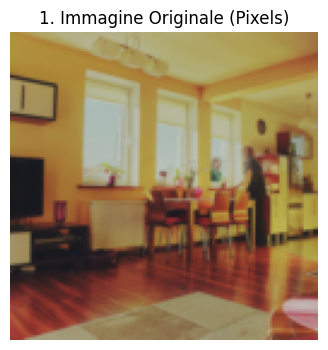

--- Inizio Test VAE e UNet ---
Latent (encoded) shape: torch.Size([1, 4, 16, 16])
Latent rumoroso (t=500) shape: torch.Size([1, 4, 16, 16])


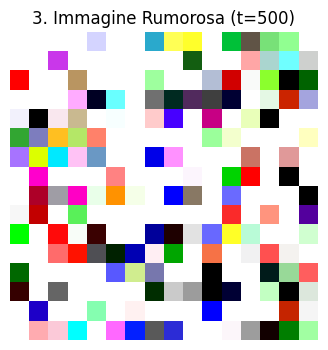

Rumore predetto (output UNet) shape: torch.Size([1, 4, 16, 16])
Test UNet OK. Inizio Training.
------------------------------


In [7]:
# --- 4. FUNZIONE DI VISUALIZZAZIONE E SETUP ---
def setup():
    """Setup del modello e loop di training."""
    
    print(f"Inizializzazione su {DEVICE}...")

    # A. Data Loading
    try:
        dataset = LatentDataset(data_dir=DATA_FOLDER, image_size=IMAGE_SIZE)
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        print(f"Dataset caricato: {len(dataset)} immagini.")
    except Exception as e:
        print(f"ERRORE: Impossibile trovare o caricare i dati in {DATA_FOLDER}. Verifica il path. {e}")
        return

    # Visualizzazione e Test Trasformazione
    example_img = dataset[0]
    print(f"Immagine originale (pixel) shape: {example_img.shape}")

    show_tensor_image(example_img, title="1. Immagine Originale (Pixels)")

    # B. Model Setup
    model = UNet(in_channels=LATENT_CHANNELS, out_channels=LATENT_CHANNELS, features=FEATURES).to(DEVICE)
    diffusion = GaussianDiffusion(timesteps=TIMESTEPS)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss() # La loss standard per DDPM è MSELoss tra rumore predetto e rumore reale

    print("--- Inizio Test VAE e UNet ---")
    
    # 1. Encoding
    dummy_pixels = example_img.unsqueeze(0).to(DEVICE)
    latents = encode_to_latent(dummy_pixels)
    print(f"Latent (encoded) shape: {latents.shape}") # Dovrebbe essere (1, 4, 16, 16) per 128x128
    
    # 2. Diffusion Forward Test (t=500)
    test_t = torch.tensor([500]).to(DEVICE)
    noisy_latents, true_noise = diffusion.forward_process(latents, test_t)
    print(f"Latent rumoroso (t=500) shape: {noisy_latents.shape}")
    show_tensor_image(noisy_latents, title=f"3. Immagine Rumorosa (t={test_t.item()})")

    # 3. UNet Prediction Test
    predicted_noise = model(noisy_latents, test_t)
    print(f"Rumore predetto (output UNet) shape: {predicted_noise.shape}")
    assert predicted_noise.shape == true_noise.shape, "Shape mismatch tra rumore predetto e reale!"

    print("Test UNet OK. Inizio Training.")
    
    print("-" * 30)

    return model, diffusion, dataloader, optimizer, criterion



model, diffusion, dataloader, optimizer, criterion = setup()
    
    


In [19]:
from torch.utils.data import Subset #
NUM_SAMPLES_FOR_SANITY_CHECK = 5000 

def small_dataset():
    
    # A. Data Loading
    try:
        # Inizializza il Dataset Completo (con la logica di caricamento file/classi esistente)
        full_dataset = LatentDataset(data_dir=DATA_FOLDER, image_size=IMAGE_SIZE)
        
        
        if len(full_dataset) > NUM_SAMPLES_FOR_SANITY_CHECK:
            # 1. Genera N indici casuali (da 0 alla dimensione totale del dataset)
            indices = torch.randperm(len(full_dataset))[:NUM_SAMPLES_FOR_SANITY_CHECK].tolist()
            
            # 2. Crea il Subset utilizzando solo questi indici
            subset_dataset = Subset(full_dataset, indices)
            
            print(f"Dataset completo caricato ({len(full_dataset)} immagini).")
            print(f"Utilizzo Subset di {len(subset_dataset)} immagini per il Sanity Check.")
        else:
            subset_dataset = full_dataset
            print("Dataset troppo piccolo. Utilizzo tutte le immagini.")

        # 3. Passa il Subset (o il full_dataset) al DataLoader
        dataloader = DataLoader(subset_dataset, batch_size=BATCH_SIZE, shuffle=True)
        
        return dataloader
        
    except Exception as e:
        print(f"ERRORE: Impossibile trovare o caricare i dati in {DATA_FOLDER}. Verifica il path. {e}")
        return

small_dataloader = small_dataset()



Dataset troppo piccolo. Utilizzo tutte le immagini.


In [20]:
# --- NUOVE COSTANTI GLOBALI NECESSARIE ---
def setup():
    """Setup del modello e preparazione dei data loader di training e validazione."""
    
    print(f"Inizializzazione su {DEVICE}...")

    # A. Data Loading & Splitting
    try:
        # 1. Carica il Dataset Completo
        full_dataset = LatentDataset(data_dir=DATA_FOLDER, image_size=IMAGE_SIZE)
        
        # 2. Definisci le dimensioni dello split
        val_size = int(VALIDATION_SPLIT_RATIO * len(full_dataset))
        train_size = len(full_dataset) - val_size
        
        # 3. SPLIT DETERMINISTICO (Usiamo un seed per la riproducibilità!)
        torch.manual_seed(42)
        train_dataset, val_dataset = random_split(
            full_dataset, [train_size, val_size]
        )
        
        # 4. Crea i DataLoader separati
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

        print(f"Dataset caricato: Totale {len(full_dataset)} immagini.")
        print(f" -> Train Loader: {len(train_dataset)} immagini ({len(train_loader)} batches)")
        print(f" -> Validation Loader: {len(val_dataset)} immagini ({len(val_loader)} batches)")

    except Exception as e:
        print(f"ERRORE: Impossibile trovare o caricare i dati in {DATA_FOLDER}. Verifica il path. {e}")
        return

    # B. Model Setup
    model = UNet(in_channels=LATENT_CHANNELS, out_channels=LATENT_CHANNELS, features=FEATURES).to(DEVICE)
    diffusion = GaussianDiffusion(timesteps=TIMESTEPS)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss() 

    # 5. Restituisce il modello, la diffusione e I DUE DATALOADER
    return model, diffusion, train_loader, val_loader, optimizer, criterion

model, diffusion, train_loader, val_loader, optimizer, criterion = setup()

Inizializzazione su cuda...
Dataset caricato: Totale 5000 immagini.
 -> Train Loader: 4000 immagini (125 batches)
 -> Validation Loader: 1000 immagini (32 batches)


In [25]:
EPOCHS = 100 
def train(model, diffusion, train_loader, val_loader, optimizer, criterion):
    """
    Esegue il loop di training DDPM, salvando i pesi e i metadati.
    Include la validazione inline (senza funzione esterna).
    """

    # Crea la cartella di salvataggio se non esiste
    os.makedirs(SAVE_FOLDER, exist_ok=True)
    
    # Inizializza la cronologia delle loss PRIMA del ciclo delle Epoche
    loss_history = {'train_loss': [], 'val_loss': []}

    for epoch in range(EPOCHS):
        
        # 1. --- FASE DI TRAINING (Modalità: model.train()) ---
        model.train() 
        total_train_loss = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} (TRAIN)")
        
        for step, batch in enumerate(train_bar):
            optimizer.zero_grad()
            
            # Logica Forward/Backward
            x_start_pixels = batch.to(DEVICE)
            x_start_latents = encode_to_latent(x_start_pixels)
            t = torch.randint(0, diffusion.timesteps, (x_start_latents.shape[0],), device=DEVICE).long()
            noise = torch.randn_like(x_start_latents)
            x_t, true_noise = diffusion.forward_process(x_start_latents, t, noise)
            predicted_noise = model(x_t, t)
            loss = criterion(predicted_noise, true_noise)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            avg_train_loss = total_train_loss / (step + 1)
            train_bar.set_postfix(loss=f'{avg_train_loss:.4f}') # Aggiorna la barra TQDM
            
        final_avg_train_loss = total_train_loss / len(train_loader) 
            
        # 2. --- FASE DI VALIDAZIONE (Dopo il ciclo di training) ---
        
        # Disattiva il calcolo del gradiente per la valutazione
        with torch.no_grad():
            model.eval() # Imposta il modello in modalità valutazione (disattiva dropout/batchnorm)
            total_val_loss = 0

            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [VAL]")

            for val_batch in val_bar:
                x_start_pixels = val_batch.to(DEVICE)
                x_start_latents = encode_to_latent(x_start_pixels)

                t = torch.randint(0, diffusion.timesteps, (x_start_latents.shape[0],), device=DEVICE).long()
                noise = torch.randn_like(x_start_latents)
                x_t, true_noise = diffusion.forward_process(x_start_latents, t, noise)
                
                predicted_noise = model(x_t, t)
                loss = criterion(predicted_noise, true_noise)
                
                total_val_loss += loss.item()

                avg_val_loss = total_val_loss / (val_bar.n + 1) 
                val_bar.set_postfix(loss=f'{avg_val_loss:.4f}')

            avg_val_loss = total_val_loss / len(val_loader)
            
        model.train() # Riporta il modello in modalità training per l'epoca successiva
        
        # --- LOGGING E SALVATAGGIO ---
        
        loss_history['train_loss'].append(final_avg_train_loss)
        loss_history['val_loss'].append(avg_val_loss)

        
        
        # Checkpoint: Salva lo stato completo del modello e la history
        # checkpoint_data = {
        #      'epoch': epoch + 1,
        #      'model_state_dict': model.state_dict(),
        #      'optimizer_state_dict': optimizer.state_dict(),
        #      'avg_val_loss': avg_val_loss,
        #      'loss_history': loss_history, 
        # }
        
        # checkpoint_path = os.path.join(
        #     SAVE_FOLDER, 
        #     f"{MODEL_NAME}_epoch_{epoch+1:03d}_val_{avg_val_loss:.4f}.pth"
        # )
        # torch.save(checkpoint_data, checkpoint_path)
        # print(f"Checkpoint salvato in: {checkpoint_path}")

    # --- LOGICA DI SALVATAGGIO FINALE (Fuori dal ciclo epoch) ---
    print("Training completato!")
    lr_str = str(LEARNING_RATE).replace('.', '') 
    hyper_suffix = f"T{TIMESTEPS}_LR{lr_str}_E{EPOCHS}"
    final_model_filename = f"{MODEL_NAME}_final_{hyper_suffix}.pth"
    final_model_path = os.path.join(SAVE_FOLDER, final_model_filename)

    torch.save({'state_dict': model.state_dict()}, final_model_path)
    
    print(f"Pesi e cronologia finali salvati in: {final_model_path}")
    return loss_history

loss_history = train(model, diffusion, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, criterion=criterion)

Epoch 100/100 [VAL]: 100%|██████████| 32/32 [00:25<00:00,  1.23it/s, loss=0.1855]


Training completato!
Pesi e cronologia finali salvati in: ../weights/ldm_unet_final_T1000_LR00001_E100.pth


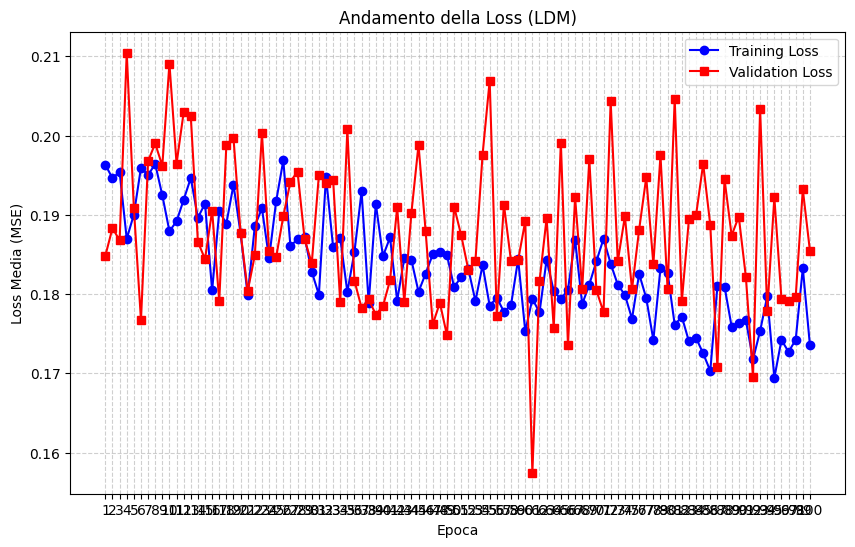

In [26]:

def plot_loss_history(history: dict):
    """
    Visualizza l'andamento delle loss di training e validazione.

    Args:
        history (dict): Dizionario contenente le liste 'train_loss' e 'val_loss'.
    """
    
    # Verifica che le chiavi necessarie siano presenti
    if 'train_loss' not in history or 'val_loss' not in history:
        print("Errore: Il dizionario history deve contenere le chiavi 'train_loss' e 'val_loss'.")
        return

    train_losses = history['train_loss']
    val_losses = history['val_loss']
    
    # Genera l'asse X (numero di epoche)
    epochs = range(1, len(train_losses) + 1) 

    plt.figure(figsize=(10, 6))
    
    # Plotta la Training Loss
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    
    # Plotta la Validation Loss
    plt.plot(epochs, val_losses, 'r-s', label='Validation Loss')
    
    # Aggiunge i dettagli al grafico
    plt.title('Andamento della Loss (LDM)')
    plt.xlabel('Epoca')
    plt.ylabel('Loss Media (MSE)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Forza i tick dell'asse X a essere interi (utile se hai poche epoche)
    plt.xticks(epochs) 
    
    plt.show()

plot_loss_history(loss_history)